In [35]:
from keras.datasets import mnist  # handwritten digits
(x_train, labels_train), (x_test, labels_test) = mnist.load_data()  # splitting, training images, training image labels ...

In [36]:
# value normalisation; format the data, convert to floating-point numbers in the range [0, 1]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [37]:
# categorical labels in the form of integers 0-9
# one hot encoding, to define the output that the network should produce in response to each sample
from keras.utils import to_categorical
y_train = to_categorical(labels_train, 10)
y_test = to_categorical(labels_test, 10)

In [38]:
# data used as input to a convolutional layer
# the first dimension corresponds to the number of exemplars
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [39]:
# to build a simple CNN using convolutional, maxpooling, as well as dense layers (and with batch normalisation and dropout for some layers)
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation, ZeroPadding2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.callbacks import LearningRateScheduler
# from keras.optimizers import Adam
net = Sequential()
net.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
net.add(BatchNormalization())
net.add(Conv2D(32, (3, 3), activation='relu'))
net.add(BatchNormalization())
# net.add(MaxPooling2D(pool_size=(2,2)))
net.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
net.add(BatchNormalization())
net.add(Dropout(0.4))
net.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
net.add(BatchNormalization())
net.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
net.add(BatchNormalization())
# net.add(MaxPooling2D(pool_size=(2,2)))
net.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
net.add(BatchNormalization())
net.add(Dropout(0.4))
net.add(Conv2D(128, kernel_size = 4, activation='relu'))
net.add(BatchNormalization())
net.add(Flatten())
net.add(Dropout(0.4))
net.add(Dense(10, activation='softmax'))

In [40]:
# loss function, optimizer helps determine how quickly the network learns
net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# history = net.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=256)

In [41]:
# ImageDataGenerator class generates batches of tensor image data with real-time data augmentation
# train_gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
#                         height_shift_range=0.08, zoom_range=0.08)
train_gen = ImageDataGenerator(rotation_range=10, zoom_range = 0.10, width_shift_range=0.1, height_shift_range=0.1)

test_gen = ImageDataGenerator()

In [42]:
# Takes data & label arrays, generates batches of augmented data
train_generator = train_gen.flow(x_train, y_train, batch_size=64)
test_generator = test_gen.flow(x_test, y_test, batch_size=64)

In [43]:
# steps_per_epoch: after having run for steps_per_epoch gradient descent steps, the fitting process will go to the next epoch
# validation_steps: tells the process how many batches to draw from the validation generator for evaluation
from keras.callbacks import ModelCheckpoint
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
checkpoint_filepath = '/Users/lee_king/Downloads/training/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
history = net.fit(train_generator, steps_per_epoch=60000//64, epochs=45, 
                    validation_data=test_generator, validation_steps=10000//64, callbacks=[annealer, model_checkpoint_callback])

Epoch 1/45
937/937 [==============================] - 158s 167ms/step - loss: 0.7466 - accuracy: 0.7723 - val_loss: 0.0320 - val_accuracy: 0.9898
INFO:tensorflow:Assets written to: /Users/lee_king/Downloads/training/checkpoint/assets
Epoch 2/45
937/937 [==============================] - 152s 162ms/step - loss: 0.1094 - accuracy: 0.9658 - val_loss: 0.0261 - val_accuracy: 0.9913
INFO:tensorflow:Assets written to: /Users/lee_king/Downloads/training/checkpoint/assets
Epoch 3/45
937/937 [==============================] - 151s 161ms/step - loss: 0.0829 - accuracy: 0.9750 - val_loss: 0.0249 - val_accuracy: 0.9929
INFO:tensorflow:Assets written to: /Users/lee_king/Downloads/training/checkpoint/assets
Epoch 4/45
937/937 [==============================] - 164s 175ms/step - loss: 0.0685 - accuracy: 0.9791 - val_loss: 0.0260 - val_accuracy: 0.9916
Epoch 5/45
937/937 [==============================] - 155s 165ms/step - loss: 0.0633 - accuracy: 0.9805 - val_loss: 0.0445 - val_accuracy: 0.9881
Epoch 

In [44]:
net.save("cnn_network_for_mnist.h5")

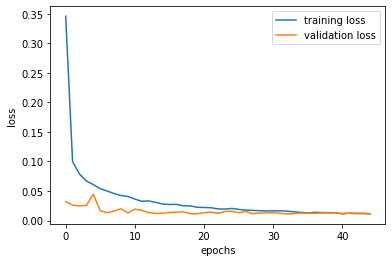

In [45]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [47]:
from keras.models import load_model, save_model
pb_model_dir = "/Users/lee_king/Downloads/training/saved_model"
h5_model = "/Users/lee_king/Downloads/training/cnn_for_mnist.h5"
model = load_model(pb_model_dir)
save_model(model, h5_model)
net = load_model(h5_model)

In [48]:
# testing a neural network
import numpy as np
outputs = net.predict(x_test)  # predict testing images in mnist
labels_predicted = np.argmax(outputs, axis=1)  # argmax returns indices of maximum outputs
misclassified = sum(labels_predicted != labels_test)  # count the number of misclassified labels
print("percentage of misclassfied: ", 100*misclassified/labels_test.size)

percentage of misclassfied:  0.35
